In [1]:
%pip install -r requirements.txt

ERROR: Could not find a version that satisfies the requirement tensorflow==2.8.0 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1)
ERROR: No matching distribution found for tensorflow==2.8.0
Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline
import tensorflow as tf
import keras as k
from keras import layers

from keras_preprocessing.image import ImageDataGenerator
from keras.models import clone_model
from keras.applications import ResNet50

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

import cv2
import os
#import shutil

from PIL import Image

2024-02-02 00:22:49.259787: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-02 00:22:49.259846: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-02 00:22:49.331222: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-02 00:22:49.464594: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-02 00:22:50.602217: W tensorflow/compiler/tf2

In [2]:
def conv_block(inputs, filters_n):
    n = layers.Conv2D(filters_n, 3, padding="same")(inputs)
    n = layers.BatchNormalization()(n)
    n = layers.Activation("relu")(n)
    
    n = layers.Conv2D(filters_n, 3, padding="same")(n)
    n = layers.BatchNormalization()(n)
    n = layers.Activation("relu")(n)
    
    return n

def encoder_block(inputs, filters_n):
    x = conv_block(inputs, filters_n)
    p = layers.MaxPool2D(pool_size=(2,2))(x)
    return x, p

def decoder_block(inputs, skip, filters_n):
    x = layers.Conv2DTranspose(filters_n, kernel_size=(2,2), strides=2, padding="same")(inputs)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters_n)
    return x


def U_Net(input_shape):
    inputs = layers.Input(shape=input_shape)
    inputs2 = layers.Rescaling(1. /255)(inputs)
    resnet50 = k.applications.ResNet50(include_top=False, weights="imagenet", input_tensor=inputs2)

    #encode
    s1 = resnet50.get_layer("input_1").output  #512x512
    s2 = resnet50.get_layer("conv1_relu").output  #256x256
    s3 = resnet50.get_layer("conv2_block3_out").output  #128x128
    s4 = resnet50.get_layer("conv3_block4_out").output  #64x64

    #bottleneck
    bottleneck = resnet50.get_layer("conv4_block6_out").output  #32x32

    #decode
    decode1 = decoder_block(bottleneck, s4, 512)
    decode2 = decoder_block(decode1, s3, 256)
    decode3 = decoder_block(decode2, s2, 128)
    decode4 = decoder_block(decode3, s1, 64)
    
    #condense 
    outputs = layers.Conv2D(1,1, padding="same", activation="sigmoid")(decode4)
    model = k.Model(inputs=inputs, outputs=outputs, name="unet")
    return model

model = U_Net((256,256,3))
model.summary()
model.save("seg_model.keras")

2024-02-01 22:56:09.380393: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-01 22:56:09.570457: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-01 22:56:09.570504: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-01 22:56:09.572505: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-01 22:56:09.572546: I external/local_xla/xla/stream_executor

Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 256, 256, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['rescaling[0][0]']           
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                               

In [3]:
#classification

def classi(input_shape):
    inputs = layers.Input(shape=input_shape)
    #vgg19 = k.applications.VGG19(include_top=False, weights="imagenet", input_tensor=inputs)
    #x = vgg19(inputs, training=False)
    densenet121 = k.applications.DenseNet121(include_top=False, input_tensor=inputs)
    x = densenet121(inputs, training=True)
    
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.BatchNormalization()(x)
    #classi layers
    for filters in [96, 128]:#, 256]:#, 320]:#, 512]:#, 1024, 2048]:
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.Activation("relu")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.Activation("relu")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPool2D(3, strides=2, padding="same")(x)
    
    #output
    x = layers.Dropout(rate=0.2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)

    output = layers.Dense(7, activation="softmax")(x)

    model = k.Model(inputs=inputs, outputs=output, name="classification")
    return model

classification = classi((256,256,3))
classification.summary()

classification.save("classification.keras")

2024-02-02 00:23:04.175772: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-02 00:23:04.364314: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-02 00:23:04.364374: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-02 00:23:04.366999: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-02 00:23:04.367071: I external/local_xla/xla/stream_executor

Model: "classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 8, 8, 1024)        7037504   
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 64)          589888    
                                                                 
 activation (Activation)     (None, 8, 8, 64)          0         
                                                                 
 batch_normalization (Batch  (None, 8, 8, 64)          256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 96)          55392     
                                                    

In [4]:
def load_folder_imgs(folder, numimgs, startind, img_shape):
    images = []
    folderfiles = os.listdir(folder)
    for i in range(numimgs):
        if len(folderfiles) > i+startind+1: 
            img = cv2.imread(os.path.join(folder,folderfiles[i+startind]))
            if img is not None:
                images.append(np.array(cv2.resize(img, dsize=img_shape)))
    return [images, i+startind]

seg_datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=360,
                             horizontal_flip=True,
                             vertical_flip=True,
                             width_shift_range=0.15,
                             height_shift_range=0.15
                             )

cls_datagen = ImageDataGenerator(rotation_range=0,
                                horizontal_flip=True,
                                vertical_flip=True,
                                width_shift_range=0.15,
                                height_shift_range=0.15
                                )

In [5]:
cls_train_gt = 'train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv'#("classi/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv")
cls_val = r'validation/ISIC2018_Task3_Validation_Input/'
cls_val_gt = "validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv"

#weighted binary loss
def get_weights(labels):
    cols = len(labels.columns)-2 #assumes 1 column for image ids
    weights = {}
    for i in range(cols+1):
        weights[i] = 1-np.mean(labels[labels.columns[i+1]].tolist())
    return weights

print(get_weights(pd.read_csv(cls_train_gt)))

from keras import backend as K
def f_score(y_true, y_pred, threshold=0.1, beta=2):
    tp = tp_score(y_true, y_pred, threshold)
    fp = fp_score(y_true, y_pred, threshold)
    fn = fn_score(y_true, y_pred, threshold)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return (1+beta**2) * ((precision * recall) / ((beta**2)*precision + recall))

def tp_score(y_true, y_pred, threshold=0.1):
    tp_3d = K.concatenate(
        [
            K.cast(K.expand_dims(K.flatten(y_true)), 'bool'),
            K.cast(K.expand_dims(K.flatten(K.greater(y_pred, K.constant(threshold)))), 'bool'),
            K.cast(K.ones_like(K.expand_dims(K.flatten(y_pred))), 'bool')
        ], axis=1
    )
    tp = K.sum(K.cast(K.all(tp_3d, axis=1), 'int32'))
    return tp

def fp_score(y_true, y_pred, threshold=0.1):
    fp_3d = K.concatenate(
        [
            K.cast(K.expand_dims(K.flatten(K.abs(y_true - K.ones_like(y_true)))), 'bool'),
            K.cast(K.expand_dims(K.flatten(K.greater(y_pred, K.constant(threshold)))), 'bool'),
            K.cast(K.ones_like(K.expand_dims(K.flatten(y_pred))), 'bool')
        ], axis=-1
    )

    fp = K.sum(K.cast(K.all(fp_3d, axis=1), 'int32'))
    return fp

def fn_score(y_true, y_pred, threshold=0.1):
    fn_3d = K.concatenate(
        [
            K.cast(K.expand_dims(K.flatten(y_true)), 'bool'),
            K.cast(K.expand_dims(K.flatten(K.abs(K.cast(K.greater(y_pred, K.constant(threshold)), 'float') - K.ones_like(y_pred)))), 'bool'),
            K.cast(K.ones_like(K.expand_dims(K.flatten(y_pred))), 'bool')
        ], axis=1
    )

    fn = K.sum(K.cast(K.all(fn_3d, axis=1), 'int32'))
    return fn

def precision_score(y_true, y_pred, threshold=0.1):
    tp = tp_score(y_true, y_pred, threshold)
    fp = fp_score(y_true, y_pred, threshold)
    return tp / (tp + fp)

def recall_score(y_true, y_pred, threshold=0.1):
    tp = tp_score(y_true, y_pred, threshold)
    fn = fn_score(y_true, y_pred, threshold)
    return tp / (tp + fn)


{0: 0.888866699950075, 1: 0.3305042436345482, 2: 0.9486769845232151, 3: 0.9673489765351972, 4: 0.8902646030953569, 5: 0.9885172241637543, 6: 0.9858212680978532}


In [6]:
# For loading classification labels and images.
# Standard Function, random sampling
def load_images_and_labels(images_path, labels_path, batch_size, image_shape, verbose=False):
    ds_images = []
    ds_labels = []
    data_indexes = []
    labels = pd.read_csv(labels_path)
    images = os.listdir(images_path)
    if verbose:
        print(f"loading images from {images_path} and labels from {labels_path}")
    for i in range(batch_size):
        random_index = np.random.randint(0, len(images)-2)
        if random_index >= len(images):
            random_index -=1
        img = cv2.imread(os.path.join(images_path, images[random_index]))
        row = labels.iloc[random_index, 1:]

        if img is not None and row is not None:
            if random_index not in data_indexes:
                data_indexes.append(random_index)
                ds_images.append(np.array(cv2.resize(img, dsize=image_shape)))
                ds_labels.append(row.values)
    return np.array(ds_images).astype(np.int16), np.array(ds_labels).astype(np.int16)

# Equal Sampling
def load_images_and_labels_equal(images_path, labels_path, batch_size, num_classes, image_shape, verbose=False):
    ds_images = []
    ds_labels = []
    samples_per_class = []
    class_indexes = []
    labels = pd.read_csv(labels_path)
    images = os.listdir(images_path)
    for i in range(num_classes):
        samples_per_class.append(batch_size//num_classes)
    for i in range(batch_size%num_classes):
        samples_per_class[i] += 1
    instances_per_class = labels.sum(axis=0, numeric_only=True)
    if verbose:
        print(f"loading images from {images_path} and labels from {labels_path} with equal sampling")
    for i in range(num_classes):
        #get all row indexes with 1 in ith row
        class_indexes = []
        p = 0
        for x in labels.iloc:
            if x[i+1] == 1:
                class_indexes.append(p)
            p+=1
        print(f"samples for {i} class: {samples_per_class[i]}, class_indexes len: {len(class_indexes)}")
        for x in range(samples_per_class[i]):
            random_index = np.random.randint(0, instances_per_class[i])
            ind = class_indexes[random_index]
            img = cv2.imread(os.path.join(images_path, images[ind]))
            row = labels.iloc[ind, 1:]
            if img is not None and row is not None:
                if not (samples_per_class[i] >= len(class_indexes)-1):               
                    class_indexes.pop(random_index)
                    instances_per_class[i] -= 1
                ds_images.append(np.array(cv2.resize(img, dsize=image_shape), dtype="uint8"))
                ds_labels.append(row.values)
        print("1 class loaded")
        print(f"len ds_images: {len(ds_images)}")
        print(f"len ds_labels: {len(ds_labels)}")
    return np.array(ds_images).astype(np.uint8), np.array(ds_labels).astype(np.uint8)


In [7]:
#classification = k.models.load_model('classification.keras') #reset weights
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
classification.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["binary_accuracy", f_score, precision_score, 'AUC']) 

callback_list = []#[tf.keras.callbacks.EarlyStopping(patience=5)] #can adjust to improve accuracy
"""
batch_size=32
spe = 2 #steps per epoch
epochs = 50 # set to 1 for debugging purposes
"""

seed = 123

cls_val = r'validation/ISIC2018_Task3_Validation_Input/'
cls_val_gt = "validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv"

cls_train = r'train/ISIC2018_Task3_Training_Input/'#r"classi/ISIC2018_Task3_Training_Input/ISIC2018_Task3_Training_Input/" 
cls_train_gt = 'train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv'#("classi/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv")


epochs=50
batch_size = 2
spe=16
"""
length=len(pd.read_csv(cls_train_gt))//64
b_max= 60 # set this based on  how much your  memory can hold
batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and 
                  length/n<=b_max],reverse=True)[0] 
spe=int(length/batch_size)
"""

print(batch_size*spe*epochs)
train_ds, train_gt = load_images_and_labels_equal(cls_train, cls_train_gt, batch_size*spe*epochs, 7, (256,256), True)
val_ds, val_gt = load_images_and_labels_equal(cls_val, cls_val_gt, batch_size*spe*epochs//2, 7, (256,256), True)
print(f"train_ds len: {len(train_ds)}, train labels len: {len(train_gt)}")
print(f"val_ds len: {len(val_ds)}, val labels len: {len(val_gt)}")
cls_train_gen = cls_datagen.flow(x=train_ds, y=train_gt, seed=seed, batch_size=batch_size*spe, shuffle=False)
val_train_gen = cls_datagen.flow(x=val_ds, y=val_gt, seed=seed, batch_size=batch_size*spe//2, shuffle=False)

history = classification.fit(cls_train_gen, steps_per_epoch=len(cls_train_gen.x)//cls_train_gen.batch_size, epochs=epochs,
                                #class_weight=get_weights(pd.read_csv(cls_train_gt)), 
                                batch_size=batch_size, callbacks=callback_list, verbose=1,
                                validation_data=(val_train_gen.x, val_train_gen.y), validation_steps=len(val_train_gen.x)//val_train_gen.batch_size)

print(f"--------------- Done training -----------------")



1600
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv with equal sampling
samples for 0 class: 229, class_indexes len: 1113
1 class loaded
len ds_images: 229
len ds_labels: 229
samples for 1 class: 229, class_indexes len: 6705
1 class loaded
len ds_images: 458
len ds_labels: 458
samples for 2 class: 229, class_indexes len: 514
1 class loaded
len ds_images: 687
len ds_labels: 687
samples for 3 class: 229, class_indexes len: 327
1 class loaded
len ds_images: 916
len ds_labels: 916
samples for 4 class: 228, class_indexes len: 1099
1 class loaded
len ds_images: 1144
len ds_labels: 1144
samples for 5 class: 228, class_indexes len: 115
1 class loaded
len ds_images: 1372
len ds_labels: 1372
samples for 6 class: 228, class_indexes len: 142
1 class loaded
len ds_images: 1600
len ds_labels: 1600
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from vali

2024-02-02 00:23:56.468013: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inclassification/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-02-02 00:23:58.277209: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-02 00:23:58.410990: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-02 00:23:58.597629: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-02 00:24:00.903925: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f7d60111110 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-02 00:24:00.903956: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RT

50/50 [==============================] - ETA: 0s - loss: 2.4744 - binary_accuracy: 0.8348 - f_score: 0.3112 - precision_score: 0.1331 - auc: 0.4819

2024-02-02 00:24:22.370887: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 618921984 exceeds 10% of free system memory.
2024-02-02 00:24:22.809176: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 618921984 exceeds 10% of free system memory.


50/50 [==============================] - 43s 346ms/step - loss: 2.4744 - binary_accuracy: 0.8348 - f_score: 0.3112 - precision_score: 0.1331 - auc: 0.4819 - val_loss: 2.1584 - val_binary_accuracy: 0.8571 - val_f_score: nan - val_precision_score: 0.1286 - val_auc: 0.1902
Epoch 2/50
50/50 [==============================] - 14s 271ms/step - loss: 2.3529 - binary_accuracy: 0.8450 - f_score: 0.3163 - precision_score: 0.1281 - auc: 0.4618 - val_loss: 2.2100 - val_binary_accuracy: 0.8571 - val_f_score: nan - val_precision_score: 0.1083 - val_auc: 0.1374
Epoch 3/50
50/50 [==============================] - 14s 284ms/step - loss: 2.2778 - binary_accuracy: 0.8508 - f_score: 0.3327 - precision_score: 0.1312 - auc: 0.4686 - val_loss: 1.9108 - val_binary_accuracy: 0.8571 - val_f_score: nan - val_precision_score: 0.1415 - val_auc: 0.5850
Epoch 4/50
50/50 [==============================] - 15s 287ms/step - loss: 2.2356 - binary_accuracy: 0.8505 - f_score: 0.3462 - precision_score: 0.1348 - auc: 0.4697

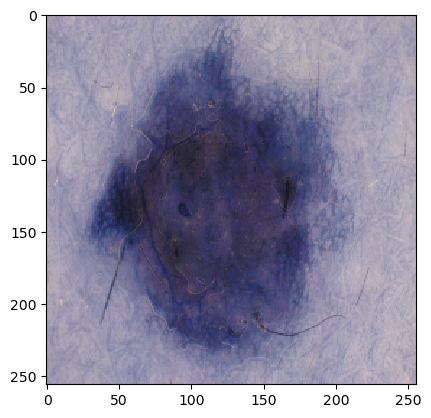

In [18]:
a = np.array(cls_train_gen.x[3], dtype="uint8")
plt.imshow(a, interpolation="nearest")
plt.show()

(Currently always returns DF)

loading images from test/ISIC2018_Task3_Test_Input and labels from test_ground_truth/ISIC2018_Task3_Test_GroundTruth/ISIC2018_Task3_Test_GroundTruth.csv
30/30 [==============================] - 4s 100ms/step


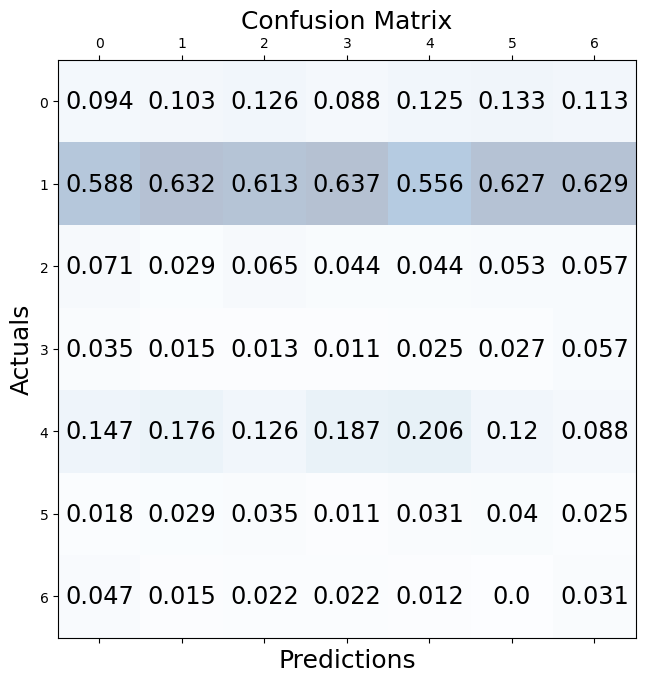

In [9]:
x_test_path = "test/ISIC2018_Task3_Test_Input"
y_test_path = "test_ground_truth/ISIC2018_Task3_Test_GroundTruth/ISIC2018_Task3_Test_GroundTruth.csv"

x_test, y_test = load_images_and_labels(x_test_path, y_test_path, len(pd.read_csv(y_test_path)), (256,256), True)

y_prediction = classification.predict(x_test)
y_prediction = np.argmax (y_prediction, axis = 1)
y_test=np.argmax(y_test, axis=1)
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_prediction , normalize='pred')
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(result, cmap=plt.cm.Blues, alpha=0.3)
for i in range(result.shape[0]):
    for j in range(result.shape[1]):
        ax.text(x=j, y=i,s=np.round(result[i, j], 3), va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

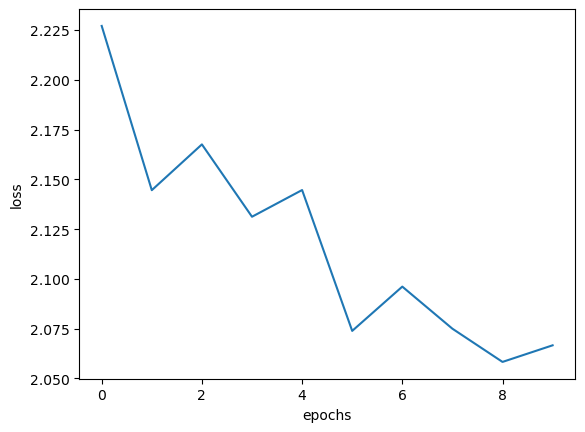

In [20]:
#eval
train_loss = history.history['loss']
val_loss   = history.history['val_loss']
#train_acc  = history.history['acc']
#val_acc    = history.history['val_acc']
xc         = range(10)

plt.figure()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot(xc, train_loss)
#plt.plot(xc, val_loss)

Save the classification model as a .tflite file.

In [10]:
def convert_to_tflite(model, name):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    # Save the model.
    with open(str(name), 'wb') as f:
      f.write(tflite_model)

""" LOADING
TF_MODEL_FILE_PATH = 'cls_model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)
interpreter.get_signature_list()

classify_lite = interpreter.get_signature_runner('serving_default')

predictions_lite = classify_lite(sequential_1_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)
"""

" LOADING\nTF_MODEL_FILE_PATH = 'cls_model.tflite' # The default path to the saved TensorFlow Lite model\n\ninterpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)\ninterpreter.get_signature_list()\n\nclassify_lite = interpreter.get_signature_runner('serving_default')\n\npredictions_lite = classify_lite(sequential_1_input=img_array)['outputs']\nscore_lite = tf.nn.softmax(predictions_lite)\n"

In [11]:
convert_to_tflite(classification, "cls_final_withresampling3.tflite")

INFO:tensorflow:Assets written to: /tmp/tmpxyn9_qj4/assets


INFO:tensorflow:Assets written to: /tmp/tmpxyn9_qj4/assets


(450, 600, 3)
(256, 256, 3)
sig_dict = {'serving_default': {'inputs': ['input_2'], 'outputs': ['dense_2']}}
sig = serving_default
True Label:            image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
40  ISIC_0034565  0.0  0.0  1.0    0.0  0.0  0.0   0.0
Predicted Scores: [[8.1152202e-06 2.9244410e-07 8.3457191e-10 6.6245886e-13 3.8272970e-05
  9.9995244e-01 7.9887690e-07]]


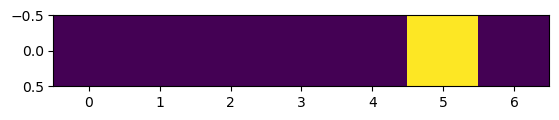

This image most likely belongs to DF with a 31.18 percent confidence.


In [8]:
#Individual Image Testing
class_names=["MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"]

pred_folder = "test/ISIC2018_Task3_Test_Input"
pred_image = "ISIC_0034565"
labels_path = "test_ground_truth/ISIC2018_Task3_Test_GroundTruth/ISIC2018_Task3_Test_GroundTruth.csv"
#classification = k.models.load_model("final_class.keras", custom_objects={"f_score": f_score, "precision_score": precision_score}) # make sure to run only after training the classification model


pred_label_df = pd.read_csv(labels_path)
pred_label_true = pred_label_df.loc[pred_label_df['image']==pred_image]

test_image = np.array(cv2.imread(os.path.join(pred_folder, pred_image) + ".jpg"))
print(test_image.shape)
#plt.imshow(test_image, interpolation='nearest')
#plt.show()

pred_image = cv2.resize(test_image, (256,256))
print(pred_image.shape)

img_array = tf.keras.utils.img_to_array(pred_image)
img_array = tf.expand_dims(img_array, 0) # Create a batch

TF_MODEL_FILE_PATH = 'cls_final_withresampling3.tflite' # The default path to the saved TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)
sig_dict = interpreter.get_signature_list()
print(f"sig_dict = {sig_dict}")
sig = list(sig_dict)[0]
print(f'sig = {sig}')
classify_lite = interpreter.get_signature_runner('serving_default')
print(classify_lite)
predictions_lite = classify_lite(input_2=img_array)['dense_2']
score_lite = tf.nn.softmax(predictions_lite)
label_name = class_names[np.argmax(score_lite)]
confidence_percent = 100 * np.max(score_lite)


print(f"True Label: {pred_label_true}")

print(f"Predicted Scores: {predictions_lite}")
plt.imshow(predictions_lite, interpolation="nearest")
plt.show()

print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(label_name, confidence_percent))

In [11]:
model = k.models.load_model('seg_model.keras') #reset weights
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=["binary_accuracy", 'MeanSquaredError', 'AUC']) 

callback_list = [tf.keras.callbacks.EarlyStopping(patience=2)] #can adjust to improve accuracy
batchsize=8
spe = 32 #steps per epoch
currentindx1=0
currentindy1=0
currentindx2=0
currentindy2=0
epochs = 80

seg_X_path = "train_seg/ISIC2018_Task1-2_Training_Input"
seg_y_path = "train_seg_gt/ISIC2018_Task1_Training_GroundTruth"

seg_val_X_path = "validation_seg/ISIC2018_Task1-2_Validation_Input"
seg_val_y_path = "validation_seg_gt/ISIC2018_Task1_Validation_GroundTruth"

for i in range(epochs+1):
    currentindy1=currentindx1
    currentindy2=currentindy2
    seg_x = load_folder_imgs(seg_X_path, batchsize, currentindx1, (256,256))
    seg_y = load_folder_imgs(seg_y_path, batchsize, currentindy1, (256,256))
    seg_val_x = load_folder_imgs(seg_val_X_path, batchsize, currentindx2, (256,256))
    seg_val_y = load_folder_imgs(seg_val_y_path, batchsize, currentindy2, (256,256))

    train_gt_X = seg_x[0] 
    train_gt_y = seg_y[0]
    currentinx1 = seg_x[1]
    currentiny1 = seg_y[1]

    val_train_gt_X = seg_val_x[0] 
    val_train_gt_y = seg_val_y[0]
    currentinx2 = seg_val_x[1]
    currentiny2 = seg_val_y[1]
    
    train_gt_X = [x//255 for x in train_gt_X]
    train_gt_y = [x//255 for x in train_gt_y]
    train_gt_y = [cv2.cvtColor(x, cv2.COLOR_BGR2GRAY) for x in train_gt_y]

    val_train_gt_X = [x//255 for x in val_train_gt_X]
    val_train_gt_y = [x//255 for x in val_train_gt_y]
    val_train_gt_y = [cv2.cvtColor(x, cv2.COLOR_BGR2GRAY) for x in val_train_gt_y]

    print(np.array(train_gt_y).shape)
    train_gt_X = tf.stack(train_gt_X) 
    train_gt_y = tf.stack(train_gt_y)

    val_train_gt_X = tf.stack(val_train_gt_X) 
    val_train_gt_y = tf.stack(val_train_gt_y)

    train_generator = seg_datagen.flow(x=train_gt_X, y=train_gt_y, batch_size=batchsize)
    val_generator = seg_datagen.flow(x=val_train_gt_X, y=val_train_gt_y, batch_size=batchsize)
    model.fit(train_generator, callbacks=callback_list, steps_per_epoch=spe, verbose=1, validation_data=val_generator)
    print(f"--------------- Done epoch {i} -----------------")

model.save("final_seg_res50.keras")



(8, 256, 256)


2024-01-27 17:31:40.649930: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-27 17:31:40.930679: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-27 17:31:41.563604: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-27 17:31:46.855221: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f85081cbc30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-27 17:31:46.855262: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
I0000 00:00:1706405506.899941   92210 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 [==============================] - 25s 35ms/step - loss: 0.8530 - binary_accuracy: 0.4397 - mean_squared_error: 0.2970 - auc: 0.4697 - val_loss: 0.6382 - val_binary_accuracy: 0.7129 - val_mean_squared_error: 0.2229 - val_auc: 0.4894
--------------- Done epoch 0 -----------------
(8, 256, 256)
32/32 [==============================] - 1s 8ms/step - loss: 0.6554 - binary_accuracy: 0.5103 - mean_squared_error: 0.2345 - auc: 0.6949 - val_loss: 0.6414 - val_binary_accuracy: 0.7145 - val_mean_squared_error: 0.2244 - val_auc: 0.4902
--------------- Done epoch 1 -----------------
(8, 256, 256)
32/32 [==============================] - 1s 8ms/step - loss: 0.5851 - binary_accuracy: 0.7005 - mean_squared_error: 0.1981 - auc: 0.6804 - val_loss: 0.6418 - val_binary_accuracy: 0.7158 - val_mean_squared_error: 0.2246 - val_auc: 0.4910
--------------- Done epoch 2 -----------------
(8, 256, 256)
32/32 [==============================] - 1s 7ms/step - loss: 0.5323 - binary_accuracy: 0.7814 - mean_squ

(2848, 4288, 3)


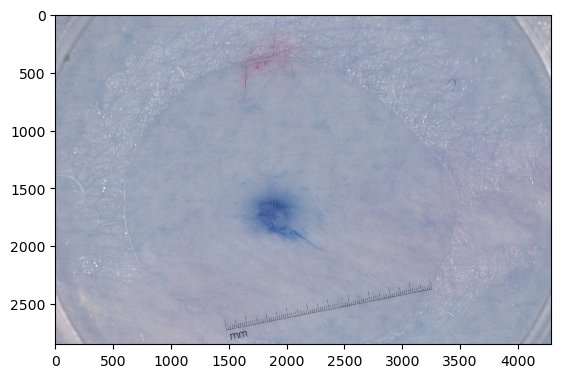

(256, 256, 3)
(1, 256, 256, 3)
1/1 [==============================] - 0s 20ms/step
(1, 256, 256, 1)
(1, 256, 256)


TypeError: Invalid shape (1, 256, 256) for image data

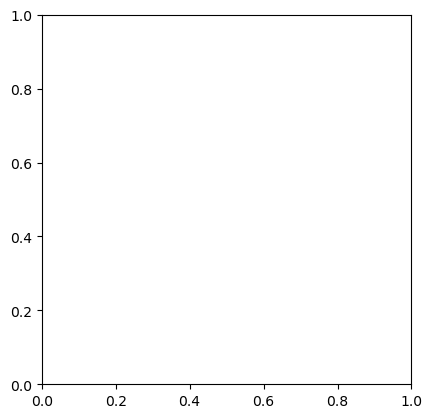

In [27]:
pred_folder = "validation_seg/ISIC2018_Task1-2_Validation_Input"

pred_image = np.array(cv2.imread(os.path.join(pred_folder,"ISIC_0012255.jpg"))) #change to another image if you wish
print(pred_image.shape)

plt.imshow(pred_image, interpolation='nearest')
plt.show()

pred_image = cv2.resize(pred_image, (256,256))
pred_image=pred_image//255
pred_image = pred_image.reshape((1,256,256,3))
pred = model.predict(pred_image)
x = pred[0,:, :, :]
print(x.shape)
plt.imshow(x, interpolation='nearest')
plt.show() 